<a href="https://colab.research.google.com/github/tushar123-hash/my-projects/blob/main/uplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras-unet-collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.6 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers

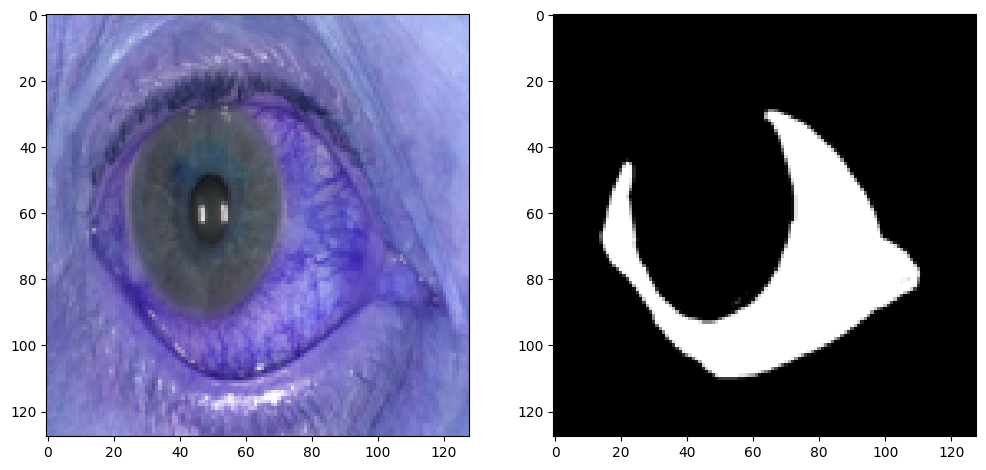

Help on function unet_plus_2d in module keras_unet_collection._model_unet_plus_2d:

unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    U-net++ with an optional ImageNet-trained backbone.
    
    unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
                 activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    
    ----------
    Zhou, Z., Siddiquee, M.M.R., Tajbakhsh, N. and Liang, J., 2018. Unet++: A nested u-net architecture 
    for medical image segmentation. In Deep Learning in Medical Image Analysis and Multimodal Learning 
    for C

/usr/local/lib/python3.10/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


Model: "unet_plus_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 VGG16_backbone (Functional  [(None, 128, 128, 64),    14714688  
 )                            (None, 64, 64, 128),               
                              (None, 32, 32, 256),               
                              (None, 16, 16, 512),               
                              (None, 8, 8, 512)]                 
                                                                 
 unet_plus_up0_from3_decode  (None, 16, 16, 512)       2359808   
 _trans_conv (Conv2DTranspo                                      
 se)                                                             
                                                                 
 unet_plus_up0_from3_decode  (None, 16, 16, 512)   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


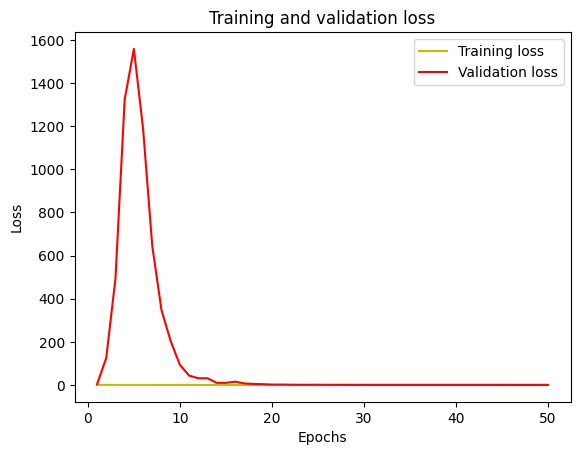

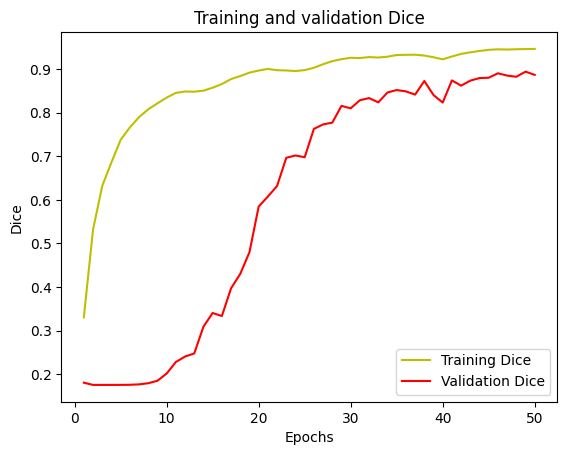

1/1 [==============================] - 0s 33ms/step


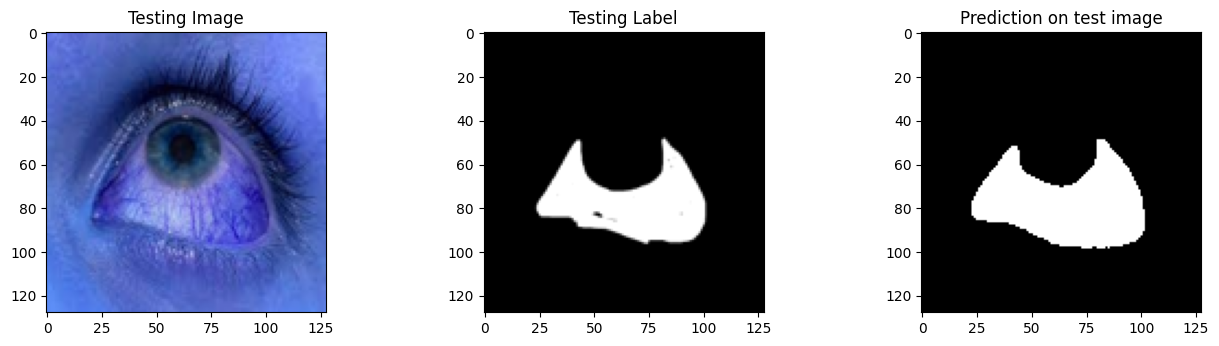

Mean IoU = 0.84132004
1/1 [==============================] - 0s 34ms/step
Mean IoU is:  [0.8685953]


In [13]:
image_directory = '/content/drive/MyDrive/Colab Notebooks/data/images/'
mask_directory = '/content/drive/MyDrive/Colab Notebooks/data/masks/'

SIZE = 128
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        # print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

  #Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(10, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
plt.show()

#######################################

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 5

###############################################################################
#Try various models: Unet, Attention_UNet, and Attention_ResUnet


from keras_unet_collection import models, losses

help(models.unet_plus_2d)

model_Unet_plus = models.unet_plus_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=num_labels,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet_plus')


model_Unet_plus.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3),
              metrics=['accuracy', losses.dice_coef])

print(model_Unet_plus.summary())

start2 = datetime.now()

Unet_plus_history = model_Unet_plus.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=50)

stop2 = datetime.now()
#Execution time of the model
execution_time_Unet_plus = stop2-start2
print("UNet plus execution time is: ", execution_time_Unet_plus)

model_Unet_plus.save('mitochondria_unet_collection_UNet_plus_50epochs.hdf5')

# future plotting
import pandas as pd
unet_plus_history_df = pd.DataFrame(Unet_plus_history.history)

with open('unet_plus_history_df.csv', mode='w') as f:
    unet_plus_history_df.to_csv(f)

#######################################################################
#Check history plots, one model at a time
history = Unet_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

model = model_Unet


import random
test_img_number = random.randint(0, X_test.shape[0]-1)  #Test with 119

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    #print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
